<a href="https://colab.research.google.com/github/dbamman/nlp22/blob/master/HW2/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import sys, argparse
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import re
from collections import Counter, defaultdict
import operator
import nltk
import csv
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from pandas import option_context

In [75]:
!python -m nltk.downloader punkt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Let's download the data we'll use for training and development, and also the data we'll use to make predictions for.

In [57]:
# Get data
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/train.txt
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/dev.txt
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/test.txt

--2022-02-02 22:44:51--  https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1322055 (1.3M) [text/plain]
Saving to: ‘train.txt.5’

train.txt.5         100%[===================>]   1.26M  --.-KB/s    in 0.02s   

2022-02-02 22:44:52 (54.0 MB/s) - ‘train.txt.5’ saved [1322055/1322055]

--2022-02-02 22:44:52--  https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/dev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1309909 (1.2M) [text/plain]
Saving to: ‘dev.txt.5’

In [58]:
trainingFile = "train.txt"
evaluationFile = "dev.txt"
testFile = "test.txt"

In [59]:
######################################################################
## Do not edit this block of code.
## This defines the classification class which
## loads the data and sets up the model.
######################################################################

class Classifier:

    def __init__(self, feature_method, L2_regularization_strength=1.0, min_feature_count=1):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.log_reg = None
        self.L2_regularization_strength=L2_regularization_strength
        self.min_feature_count=min_feature_count

        self.trainX, self.trainY, self.trainOrig = self.process(trainingFile, training=True)
        self.devX, self.devY, self.devOrig = self.process(evaluationFile, training=False)
        self.testX, _, self.testOrig = self.process(testFile, training=False)

    # Read data from file
    def load_data(self, filename):
        data = []
        with open(filename, encoding="utf8") as file:
            for line in file:
                cols = line.split("\t")
                idd = cols[0]
                label = cols[1]
                text = cols[2]

                data.append((idd, label, text))
                
        return data

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for idd, label, text in data:
            feats = self.feature_method(text)
            featurized_data.append((label, feats))
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, dataFile, training = False):
        original_data = self.load_data(dataFile)
        data = self.featurize(original_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for label, feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (label, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = label

        return X, Y, original_data

    def load_test(self, dataFile):
        data = self.load_data(dataFile)
        data = self.featurize(data)

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (data_id, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = data_id

        return X, Y

    # Train model and evaluate on held-out data
    def evaluate(self):
        (D,F) = self.trainX.shape
        self.log_reg = linear_model.LogisticRegression(C = self.L2_regularization_strength, max_iter=1000)
        self.log_reg.fit(self.trainX, self.trainY)
        training_accuracy = self.log_reg.score(self.trainX, self.trainY)
        development_accuracy = self.log_reg.score(self.devX, self.devY)
        print("Method: %s, Features: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (self.feature_method.__name__, F, training_accuracy, development_accuracy))


    # Predict labels for new data
    def predict(self):
        predX = self.log_reg.predict(self.testX)

        with open("%s_%s" % (self.feature_method.__name__, "predictions.csv"), "w", encoding="utf8") as out:
            writer=csv.writer(out)
            writer.writerow(["Id", "Expected"])
            for idx, data_id in enumerate(self.testX):
                writer.writerow([self.testOrig[idx][0], predX[idx]])
        out.close()


    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

            

*First*, let's define a classifier based on a really simple dictionary-based feature: if the abstract contains the words "love" or "like", the CONTAINS_POSITIVE_WORD feature will fire, and if it contains either "hate" or "dislike", the CONTAINS_NEGATIVE_WORD will fire.  Note how we use `nltk.word_tokenize` to tokenize the text into its discrete words.

In [60]:
def simple_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        if word == "love" or word == "like":
            feats["contains_positive_word"] = 1
        if word == "hate" or word == "dislike":
            feats["contains_negative_word"] = 1
            
    return feats


Now let's see how that feature performs on the development data.  Note the `L2_regularization_strength` specifies the strength of the L2 regularizer (values closer to 0 = stronger regularization), and the `min_feature_count` specifies how many data points need to contain a feature for it to be allowable as a feature in the model.  Both are ways to prevent the model from overfitting and achieve higher performance.

In [61]:
simple_classifier = Classifier(simple_featurize, L2_regularization_strength=1.0, min_feature_count=1)
simple_classifier.evaluate()

Method: simple_featurize, Features: 2, Train accuracy: 0.509, Dev accuracy: 0.500


First, is this accuracy score any good?  Let's calculate the accuracy of a majority class predictor to provide some context.  Again, this determines the most represented (majority) class in the training data, and then predicts every test point to be this class.

In [62]:
def majority_class(trainY, devY):
    labelCounts=Counter()
    for label in trainY:
        labelCounts[label]+=1
    majority_class=labelCounts.most_common(1)[0][0]
    
    correct=0.
    for label in devY:
        if label == majority_class:
            correct+=1
            
    print("Majority class: %s\tDev accuracy: %.3f" % (majority_class, correct/len(devY)))
majority_class(simple_classifier.trainY, simple_classifier.devY)

Majority class: pos	Dev accuracy: 0.500


# Your assignment

## Deliverable 1

Your job in this homework is to implement a binary bag-of-words model (i.e., one that assigns a feature value of 1 to each word type that is present in the text); and to brainstorm three additional distinct classes of features, justify why they might help improve the performance *over a bag of words* for this task, implement them in code, and then assess their independent performance on the development data. 

Describe your features and report their performance in the table below; implement the features in the specified `feature1`, `feature2`, and `feature3` functions, and execute each respective classifier to show its performance.  

|Feature|Why should it work? (50 words each)|Dev set performance|
|---|---|---|
|Bag of words||
|Feature 1||
|Feature 2||
|Feature 3||

Note that it is not required for your features to actually perform well, but your justification for why it *should* perform better than a bag of words should be defensible.  The most creative features (defined as features that few other students use and that are reasonably well-performing) will receive extra credit for this assignment.


In [63]:
def bag_of_words(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    def remove_special_chars(word):
      word_arr = []
      for ch in word:
        if ch == '-':
          word_arr.append(ch)
        elif 65 <= ord(ch) <= 90 or 97 <= ord(ch) <= 122:
            word_arr.append(ch)
      output = ''
      return output.join(word_arr)

    feats = {}
    for word in nltk.word_tokenize(text):
      word = remove_special_chars(word.lower())
      if word not in feats:
        feats[word] = 1
                        
    return feats

In [64]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

bow_classifier = Classifier(bag_of_words, L2_regularization_strength=1.0, min_feature_count=1)
bow_classifier.evaluate()

Method: bag_of_words, Features: 20326, Train accuracy: 1.000, Dev accuracy: 0.765


For feature1, I am looking for positive words from a large list. I found the list here: https://gist.github.com/mkulakowski2/4289437

1. I read the file 'positive.txt' and store the words into a list

2. I tokenize the text, and I also made my own helper function called "remove_special_chars" to remove punctuation, so that "Terrible!" -> "terrible"

3. I parse the tokenized text "tk_text" and see if there is any positive term. If there is, I add 1 to the dictionary "feats".

Additionally, I am trying to handle two edge scenarios: 

(i) i.e."did not like", or "did not love". In this case, the counting of positive terms, shouldn't go up. 

(ii) "it was good, but...", in this scenario, my tokenized text "tk_text" will be 'it','was','good','but'; therefore, if after a positive word, there is 'but', it shouldn't count


In conclusion, I believe this feature is valid because it searches for positive terms, and these positive terms come from a large list.

In [65]:


# POSITIVE [check if it's preceded by "not"]
def feature1(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.

    '''
    Removes special chars except '-', for hyphens words like: 'eighteenth-century'
    '''
    def remove_special_chars(word):
      word_arr = []
      for ch in word:
        if ch == '-':
          word_arr.append(ch)
        elif 65 <= ord(ch) <= 90 or 97 <= ord(ch) <= 122:
            word_arr.append(ch)
      output = ''
      return output.join(word_arr)

    '''
    Returns a list where each element is the line of the txt file
    '''
    def file_to_list(filename):
      my_file = open(filename, "r")
      content_list = my_file.readlines()
      i=0 
      while i < len(content_list):
        content_list[i] = content_list[i][:len(content_list[i])-1]
        i+=1
      return content_list

    '''
    Returns an ordered list of the top negative/positive terms
    '''
    def top_terms(text, filedata):
      arr = file_to_list(filedata)
      tk_text = nltk.word_tokenize(open(text, 'r').read())
      top = []
      dic_freq = {}
      for i in arr:
        dic_freq[i] = 0
      # removing special chars from text
      for term in tk_text:
        term = remove_special_chars(term.lower())
      # building the dictionary frequency
      for word in tk_text:
        if word in dic_freq:
          dic_freq[word] +=1
      # sorting dictionary
      dic_freq = dict(sorted(dic_freq.items(), key=lambda item: item[1], reverse=True))
      # appending the top values
      for k,v in dic_freq.items():
        top.append(k)
      return top
      
    feats = {'has_positive': 0}

    positive_arr = top_terms('train.txt', 'positive.txt')
    
    tk_text = nltk.word_tokenize(text)
    for word in tk_text:
      word = remove_special_chars(word.lower())
    
    positive = False
    i=0
    while i < len(tk_text):
      if tk_text[i] in positive_arr:
        positive = True
      else:
        for term in positive_arr:
          if tk_text[i] in term or term in tk_text[i]:
            positive = True

      if positive:
        if tk_text[i-1] != 'not':
          if i == len(tk_text) - 1:
            feats['has_positive'] += 1
          else:
            if tk_text[i+1] != 'but' or tk_text[i+1] != 'except':
              feats['has_positive'] += 1
      i+=1

    return feats


In [66]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier1 = Classifier(feature1, L2_regularization_strength=1.0, min_feature_count=1)
classifier1.evaluate()

Method: feature1, Features: 1, Train accuracy: 0.498, Dev accuracy: 0.501


For feature2, I am looking for negative terms. I applied the same logic as in feature1. 
I found the list here: https://gist.github.com/mkulakowski2/4289441

Similarly to feature1, I believe feature2 is valid too because it searches for negative terms, and these negative terms come from a large list. 

In [67]:
# NEGATIVE
def feature2(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    '''
    Removes special chars except '-', for hyphens words like: 'eighteenth-century'
    '''
    def remove_special_chars(word):
      word_arr = []
      for ch in word:
        if ch == '-':
          word_arr.append(ch)
        elif 65 <= ord(ch) <= 90 or 97 <= ord(ch) <= 122:
            word_arr.append(ch)
      output = ''
      return output.join(word_arr)

    '''
    Returns a list where each element is the line of the txt file
    '''
    def file_to_list(filename):
      my_file = open(filename, "r")
      content_list = my_file.readlines()
      i=0 
      while i < len(content_list):
        content_list[i] = content_list[i][:len(content_list[i])-1]
        i+=1
      return content_list

    '''
    Returns an ordered list of the top negative/positive terms
    '''
    def top_terms(text, filedata):
      arr = file_to_list(filedata)
      tk_text = nltk.word_tokenize(open(text, 'r').read())
      top = []
      dic_freq = {}
      for i in arr:
        dic_freq[i] = 0
      # removing special chars from text
      for term in tk_text:
        term = remove_special_chars(term.lower())
      # building the dictionary frequency
      for word in tk_text:
        if word in dic_freq:
          dic_freq[word] +=1
      # sorting dictionary
      dic_freq = dict(sorted(dic_freq.items(), key=lambda item: item[1], reverse=True))
      # appending the top values
      for k,v in dic_freq.items():
        top.append(k)
      return top

    feats = {'has_negative': 0}

    negative_arr = top_terms('train.txt', 'negative.txt')

    tk_text = nltk.word_tokenize(text)
    for word in tk_text:
      word = remove_special_chars(word.lower())

    negative = False
    i=0
    while i < len(tk_text):
      if tk_text[i] in negative_arr:
        negative = True
      else:
        for term in negative_arr:
          if tk_text[i] in term or term in tk_text[i]:
            negative = True
      if negative:
        if tk_text[i-1] != 'not':
          if i == len(tk_text) - 1:
            feats['has_negative'] += 1
          else:
            if tk_text[i+1] != 'but' or tk_text[i+1] != 'except':
              feats['has_negative'] += 1
      i+=1

    return feats

In [69]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier2 = Classifier(feature2, L2_regularization_strength=1.0, min_feature_count=1)
classifier2.evaluate()

Method: feature2, Features: 1, Train accuracy: 0.497, Dev accuracy: 0.499


For feature3, the main difference is that I'm first running my helper function called "top_terms" to collect the top negative terms. You can find "top_terms" along with my other helper functions in the cell that is before "bag_of_words"

"top_terms()" works this way:

1. For every negative/positive term, it initializes a frequency dictionary like this {term: 0, term2: 0, etc...}  
2. For every word in "text", if it matches any key in the dictionary, its count will increase
3. I'm sorting the dictionary, and returning the top nth terms as a list (by default the function returns the top 20).

The rest of the logic is identical to features1-2. Overall, I believe this is a valid feature because rather than simply taking a large list of positive/negative terms, I'm first seeing which ones appear more frequently in the text, and from that, I create my dataset from where I take my positive/negative words that I compare with each review.

In [70]:
def feature3(text):
  # Here the `feats` dict should contain the features -- the key should be the feature name, 
  # and the value is the feature value.  See `simple_featurize` for an example.
  '''
  creates the sub-array for the n-gram, "st" represents the text (or review), "l" the length, by defaul is 4
  '''
  def n_gram(st, l=4):
    arr = nltk.word_tokenize(st)
    grams = []
    i=0
    while i < len(arr):
      try:
        grams.append(arr[i:i+l])
      except:
        grams.append(arr[i:])
      i+= l - 1
    return grams

  '''
  Removes special chars except '-', for hyphens words like: 'eighteenth-century'
  '''
  def remove_special_chars(word):
    word_arr = []
    for ch in word:
      if ch == '-':
        word_arr.append(ch)
      elif 65 <= ord(ch) <= 90 or 97 <= ord(ch) <= 122:
          word_arr.append(ch)
    output = ''
    return output.join(word_arr)
  '''
  Checks if a term is in the array, or if the term is part of a word in the array
  '''
  def in_array(term, array):
    if term in array:
      return True
    else:
      for word in array:
        if term in word or word in term:
          return True
    return False

  '''
  Returns a list where each element is the line of the txt file
  '''
  def file_to_list(filename):
    my_file = open(filename, "r")
    content_list = my_file.readlines()
    i=0 
    while i < len(content_list):
      content_list[i] = content_list[i][:len(content_list[i])-1]
      i+=1
    return content_list

  '''
  Returns an ordered list of the top negative/positive terms
  '''
  def top_terms(text, filedata):
    arr = file_to_list(filedata)
    tk_text = nltk.word_tokenize(open(text, 'r').read())
    top = []
    dic_freq = {}
    for i in arr:
      dic_freq[i] = 0
    # removing special chars from text
    for term in tk_text:
      term = remove_special_chars(term.lower())
    # building the dictionary frequency
    for word in tk_text:
      if word in dic_freq:
        dic_freq[word] +=1
    # sorting dictionary
    dic_freq = dict(sorted(dic_freq.items(), key=lambda item: item[1], reverse=True))
    # appending the top values
    for k,v in dic_freq.items():
      top.append(k)
    return top

  feats = {'score': 0}
  array = n_gram(text)
  totscore = 0
  partial_score = 0

  positive_arr = top_terms('train.txt', 'positive.txt')
  negative_arr = top_terms('train.txt', 'negative.txt')

  for gram in array:
    partial_score = 0
    really_counter = 0

    for word in gram:
      if word == 'really':
        really_counter +=1

      if in_array(word, positive_arr): 
        partial_score +=1
      elif in_array(word, negative_arr):
        partial_score -=1

    if partial_score < 0:
      partial_score -= really_counter
    elif partial_score > 0:
      partial_score += really_counter
    totscore += partial_score

  feats['score'] = totscore
  return feats

In [71]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier3 = Classifier(feature3, L2_regularization_strength=1.0, min_feature_count=1)
classifier3.evaluate()

Method: feature3, Features: 1, Train accuracy: 0.532, Dev accuracy: 0.541


Next, let's combine any or all the features you have developed into one big model and make predictions on the test data.

In [72]:
def combiner_function(text):

    # Here the `all_feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
  all_feats={}
  for feature in [bag_of_words, feature1, feature2, feature3]:
    all_feats.update(feature(text))
  return all_feats

In [73]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

big_classifier = Classifier(combiner_function, L2_regularization_strength=1.0, min_feature_count=1)
big_classifier.evaluate()

#generate .csv file with prediction output on test data
big_classifier.predict()

Method: combiner_function, Features: 20328, Train accuracy: 1.000, Dev accuracy: 0.770


 ## Deliverable 2

This code will generate a file named `combiner_function_predictions.csv`; download this file (using e.g. the file manager on the left panel in Colab) and submit this to GradeScope along with your notebook; the 5 systems with the highest performance (revealed after the submission deadline) will receive extra credit for this assignment.

## Interrogating classifiers

Below you will find several ways in which you can interrogate your model to get ideas on ways to improve its performance.  **Note that nothing below this line requires any work on your part; treat these as useful tools for understanding what works and what doesn't.**

1. First, let's look at the confusion matrix of its predictions (where we can compare the true labels with the predicted labels).  What kinds of mistakes is it making?  (While this is mainly helpful in the context of multiclass classification, we can still see if there's a bias toward predicting a specific class in the binary setting as well). 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


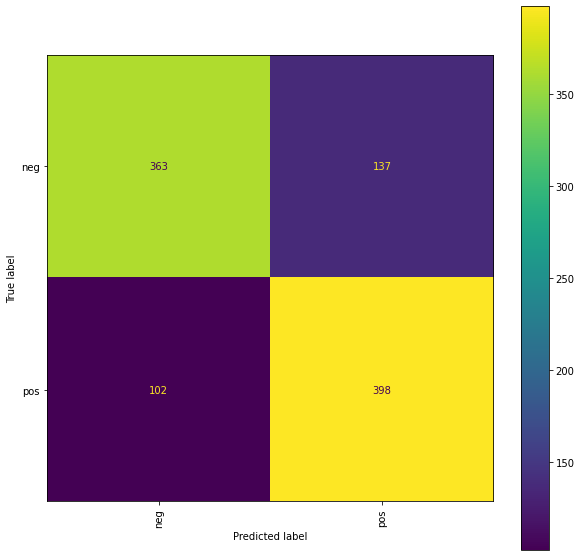

In [30]:
def print_confusion(classifier):
    fig, ax = plt.subplots(figsize=(10,10))
    plot_confusion_matrix(classifier.log_reg, classifier.devX, classifier.devY, ax=ax, xticks_rotation="vertical", values_format="d")
    plt.show()

print_confusion(big_classifier)

2. Next, let's look at the features that are most defining for each of the classes (ranked by how strong their corresponding coefficient is).  Do the features you are defining help in the ways you think they should?  Do sets of successful features suggests others, or complementary features that may provide a different view on the data?

In [31]:
big_classifier.printWeights(n=25)

pos	0.757	very
pos	0.614	excellent
pos	0.612	great
pos	0.577	enjoyed
pos	0.554	amazing
pos	0.540	simple
pos	0.534	saw
pos	0.523	incredible
pos	0.513	new
pos	0.497	different
pos	0.493	gets
pos	0.490	top
pos	0.485	man
pos	0.465	seen
pos	0.456	thought
pos	0.455	perfect
pos	0.453	us
pos	0.444	performance
pos	0.440	him
pos	0.432	my
pos	0.431	takes
pos	0.428	you
pos	0.428	relationship
pos	0.427	violence
pos	0.427	series

neg	-0.786	worst
neg	-0.727	would
neg	-0.720	acting
neg	-0.670	idea
neg	-0.655	watching
neg	-0.652	has_negative
neg	-0.548	money
neg	-0.546	actors
neg	-0.542	script
neg	-0.534	nothing
neg	-0.525	were
neg	-0.520	silly
neg	-0.518	boring
neg	-0.514	least
neg	-0.504	there
neg	-0.482	even
neg	-0.471	instead
neg	-0.466	work
neg	-0.454	maybe
neg	-0.452	waste
neg	-0.446	enough
neg	-0.442	could
neg	-0.436	something
neg	-0.430	can
neg	-0.426	fails



3. Next, let's look at the individual data points that are most mistaken. Does it suggest any features you might create to disentangle them?

In [32]:
def analyze(classifier):
    
    probs=classifier.log_reg.predict_proba(classifier.devX)
    predicts=classifier.log_reg.predict(classifier.devX)

    classes={}
    for idx, lab in enumerate(classifier.log_reg.classes_):
        classes[lab]=idx

    mistakes={}
    for i in range(len(probs)):
        if predicts[i] != classifier.devY[i]:
            predicted_lab_idx=classes[predicts[i]]
            mistakes[i]=probs[i][predicted_lab_idx]

    frame=[]
    sorted_x = sorted(mistakes.items(), key=operator.itemgetter(1), reverse=True)
    for k, v in sorted_x:
        idd=classifier.devOrig[k][0]
        text=classifier.devOrig[k][2]
        frame.append([idd, v, classifier.devY[k], predicts[k], text])

    df=pd.DataFrame(frame, columns=["id", "P(predicted class confidence)", "Human label", "Prediction", "Text"])

    with option_context('display.max_colwidth', 400):
        display(df.head(n=20))


In [33]:
analyze(big_classifier)

,id,P(predicted class confidence),Human label,Prediction,Text
0,1436,0.999671,pos,neg,I have never seen such a movie before. I was on the edge of my seat and constantly laughing throughout the entire movie. I never thought such horrible acting existed it was all just too funny. The story behind the movie is decent but the movies scenes fail to portray them. I have never seen such a stupid movie in my life which is why it I think its worth watching. I give this movie 10 out of 1...
1,1337,0.999372,pos,neg,FULL OF SPOILERS.This is a pretty fast and enjoyable crime thriller based on Ira Levin's play about two gay playwrights (Caine and Reeve) that plot the murder of one's rich wife (Cannon) to get the property and the insurance. The plot succeeds but Christopher Reeve as the younger and less established of the two writers decides to make a play out of the actual murder -- with only slight changes...
2,1178,0.998847,pos,neg,"While I do not think this was a perfect 10, I do agree it was way above a 6 which is what it's rated here. No, Brokedown Palace was not perfect and yes it's plot has been done many times before. That doesn't mean it shouldn't be done again if it is done well and I think this movie had some strong moments. The acting of Claire Danes, as already mentioned many times, was flawless as was Kate Bec..."
3,1659,0.998243,pos,neg,"Child 'Sexploitation' is one of the most serious issues facing our world today and I feared that any film on the topic would jump straight to scenes of an explicitly sexual nature in order to shock and disturb the audience. After having seen both 'Trade' and 'Holly', one film moved me to want to actually see a change in international laws. The other felt like a poor attempt at making me cry fo..."
4,1677,0.998146,neg,pos,"Hello. this is my first review for any movie i have seen. i went through the trouble of doing this to tell everyone that this is quite literally, the most disgusting movie i have ever seen. I feel like the movie was porely made, which i will give some understanding due to budget constraints on making it. I felt like i was watching a very bad remake of the movie saw. Which i can agree, saw as w..."
5,1608,0.997534,neg,pos,"As good an advert for republicanism as you're ever likely to see,""Mayerling""is an everyday story of royal folk in late nineteenth century Austria.Set during one of Europe's seemingly incessant internal turmoils it concerns itself with the Emperor Franz Joseph (Mr James Mason),his rebellious son,the Crown Prince Rudolf (Mr Omar Sharif)the Empress(Miss Ava Gardner) and various mistresses,secret ..."
6,1004,0.997367,neg,pos,"Certainly NOMAD has some of the best horse riding scenes, swordplay, and scrumptious landscape cinematography you'll likely see, but this isn't what makes a film good. It helps but the story has to shine through on top of these things. And that's where Nomad wanders.The story is stilted, giving it a sense that it was thrown together simply to make a ""cool"" movie that ""looks"" great. Not to ment..."
7,1247,0.996226,neg,pos,"Let's start by the simple lines. From the viewer's side, there a couple of good ""director details"", some points of view at the movie scenes that are nice. The special effects are good enough, a good acting/good scenery also. But the story is way too simple. It shows how a elite Army bomb squad unit lives, acts and sometimes dies. It shows the drama of living in war. In my movie experience as a..."
8,1456,0.995417,pos,neg,"Hardly a masterpiece. Not so well written. Beautiful cinematography i think not. This movie wasn't too terrible but it wasn't that much better than average. The main story dealing with highly immoral teens should have focused more on the forbidden romance and why this was... should have really gotten into it instead of scraping the surface with basically ""because mom says we can't."" Some parts..."
9,1541,0.993675,pos,neg,"Joan Fontaine here is entirely convincing as an amoral beauty who is enti